# Contents

This notebook shows two retrieval examples
- Retrieving by rplan id based on precomputed features
- Computing embeddings for a new image, and retrieving rplan images similar to it

## Functions for loading precomputed features

In [1]:
import torch

from pathlib import Path

import os
import typing

def infer_dataset_name(wandb_prefix, wandb_model_ref, features_cache_folder="data/predicted/"):
    model_folder = Path(features_cache_folder) / wandb_prefix / wandb_model_ref

    dataset_name_options = [item for item in os.listdir(model_folder) if os.path.isdir(model_folder / item)]

    if len(dataset_name_options) == 0:
        raise RuntimeError(f"No features found for {wandb_prefix}/{wandb_model_ref}. First run predict_embeddings.py")

    if len(dataset_name_options) > 1:
        raise RuntimeError(f"More than one dataset_name option was found, specify one of {dataset_name_options}")

    dataset_name = dataset_name_options[0]

    return dataset_name


def load_features(wandb_prefix, wandb_model_ref, split, dataset_name, features_cache_folder="data/predicted/") -> typing.Dict[str, torch.Tensor]:

    model_folder = Path(features_cache_folder) / wandb_prefix / wandb_model_ref

    split_options = [item for item in os.listdir(model_folder / dataset_name) if os.path.isdir(model_folder / dataset_name / item)]

    assert split in split_options, f"Did not find features for {split=}, only for {split_options}"

    features_path = Path(features_cache_folder) / wandb_prefix / wandb_model_ref / dataset_name / split / "feats.pth"
    
    return torch.load(features_path)

# Retrieve based on an rplan id in the dataset

In [2]:
from inference.retrieval_context import EmbeddingsRetrievalContext
from inference.model_context import WandbModelContext

retrieval_context = None

wandb_prefix = "emanuel/msc_thesis_models"
wandb_model_ref = "model-uc18eq89:best"
split = "val"

dataset_name = infer_dataset_name(wandb_prefix, wandb_model_ref)
features = load_features(wandb_prefix, wandb_model_ref, split, dataset_name=dataset_name)

retrieval_context = EmbeddingsRetrievalContext(features)

/media/emanuel/8de37f61-64a8-4a87-8e84-52eef99e123a/mamba_envs/micromamba/envs/floorplan-thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10/10 [00:00<00:00, 431.66it/s]


In [3]:
# If it failed, first preprocess the dataset and precompute features:

if retrieval_context is None:

    from predict_embeddings import model_huggingface_url_to_preprocessing_style

    model_context = WandbModelContext(wandb_prefix, wandb_model_ref)
    method = model_huggingface_url_to_preprocessing_style(model_context.huggingface_dataset)

    rplan_dataset_path = "/home/emanuel/thesisdata/dataset/floorplan_dataset"

    # Preprocess dataset:
    if not os.path.exists(f"data/processed/{method.value}/{split}"):
        print(f"Run: python run_preprocessing.py method={method.name} rplan_dataset_path={rplan_dataset_path} split={split}")
        !python run_preprocessing.py method={method.name} rplan_dataset_path={rplan_dataset_path} split={split}

    # Precompute features:
    print(f"Run: python predict_embeddings.py wandb_prefix={wandb_prefix} wandb_model_ref={wandb_model_ref} split={split}")
    !python predict_embeddings.py wandb_prefix={wandb_prefix} wandb_model_ref={wandb_model_ref} split={split}

# Now exectute the cell above again

In [4]:
import datasets
from visualization.visualize_retrievals import VisualizeRetrievals, FloorPlanImages

# By default uses the same dataset as the model, you can set it to:
# dataset_name = "ds_rplanpy_rgb"
# for nicer visualizations
ds_images = datasets.load_from_disk(f"data/processed/{dataset_name}/{split}/")

visualize_retrievals = VisualizeRetrievals(FloorPlanImages(ds_images))

In [5]:
dataset_name

'ds_rplanpy_rgb'

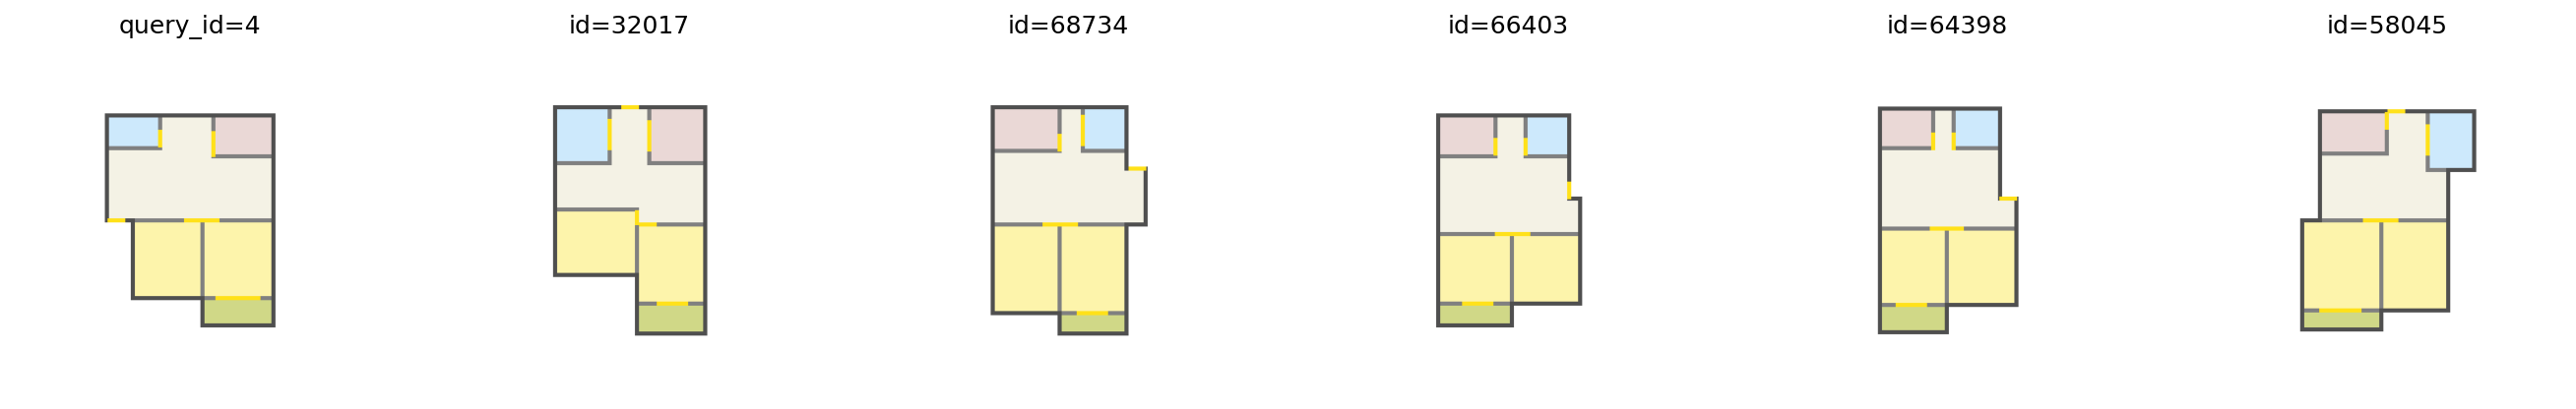

In [6]:
show_top_k = 5

query_ids = [4]

assert retrieval_context is not None

retrieved_idss = retrieval_context.retrieve(query_ids)[:, :show_top_k]

for query_id, retrieved_ids in zip(query_ids, retrieved_idss):
    plot = visualize_retrievals.visualize_query_by_id(query_id, retrieved_ids)

# Retrieve based on a new image

In [7]:
from inference.model_context import WandbModelContext

model_ctx = WandbModelContext("emanuel/msc_thesis_models", "model-uc18eq89:best")

model_ctx.model.cpu()
model = model_ctx.model.eval()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanuel. Use `wandb login --relogin` to force relogin


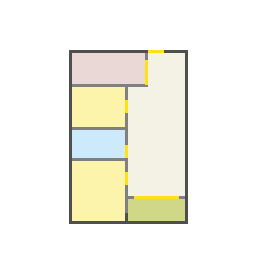

In [8]:
from PIL import Image
import numpy as np

# Open an image to use as query
query_img = Image.open("data/example_edited_query_images/rplan-0-squared-version.png").convert("RGB")

query_img

In [9]:
assert np.array(query_img).shape == (256, 256, 3)

In [10]:
import torch

from torchvision.transforms.functional import to_tensor

with torch.no_grad():
    repr_vector = model_ctx.model({"img": to_tensor(query_img).unsqueeze(0)})

query_embeddings = repr_vector["pred"]

query_embeddings.shape

torch.Size([1, 512])

In [11]:
from inference.retrieval_context import EmbeddingsRetrievalContext

wandb_prefix = "emanuel/msc_thesis_models"
wandb_model_ref = "model-uc18eq89:best"
split = "val"

dataset_name = infer_dataset_name(wandb_prefix, wandb_model_ref)
features = load_features(wandb_prefix, wandb_model_ref, split, dataset_name=dataset_name)

retrieval_context = EmbeddingsRetrievalContext(features)

ds_images = datasets.load_from_disk(f"data/processed/{dataset_name}/{split}/")

visualize_retrievals = VisualizeRetrievals(FloorPlanImages(ds_images))

100%|██████████| 10/10 [00:00<00:00, 452.85it/s]

In [12]:
retrieved_ids = retrieval_context.retrieve_by_embedding(query_embeddings, top_k=100)[0][:10]

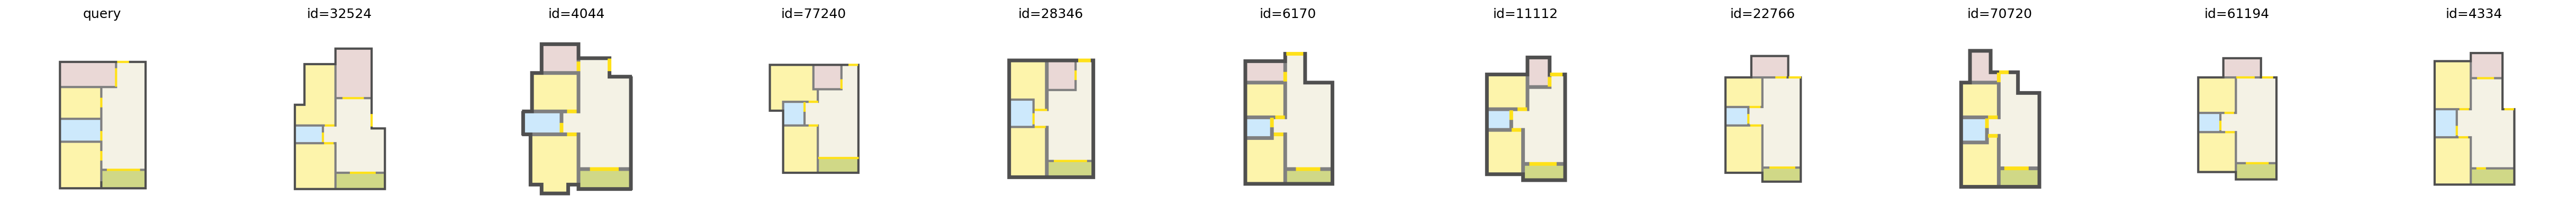

In [13]:
plot = visualize_retrievals.visualize_query_by_image(retrieved_ids, query_img)